In [1]:
%matplotlib notebook

Plots for Fig1S4

Illustrate the tracking with plots at different steps.

Also explained here: https://pivr.readthedocs.io/en/latest/code_explanation.html#animal-tracking

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas 
import os
import scipy
from scipy import ndimage
from skimage.measure import regionprops, label
import matplotlib.patches as patches
import operator
import matplotlib.gridspec as gridspec
from skimage import morphology
#plt.style.use('ggplot')
import json
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FixedLocator
import os
from pathlib import Path

In [3]:
home_path = os.getcwd()
# set to true to save plots
save_plots = False

In [4]:
datapath = Path('data/detection_data/')
os.chdir(home_path)
os.chdir(datapath)
all_images = np.load('all_images.npy')
targetpath = Path('plots/Fig1S4/')

In [5]:
class FindROI:
    '''
    This class is used to define the region of interest from a given regionpropertie class.
    It also makes sure that the box is never outside of the frame.
    '''
    def __init__(self, regionproperties, boxsize, size_factor,image):

        self.regionproperties = regionproperties
        self.boxsize = boxsize
        self.size_factor = size_factor
        self.image = image

        self.row_min = 0
        self.row_max = 0
        self.col_min = 0
        self.col_max = 0

        self.centroid_row = 0
        self.centroid_col = 0

        self.assign()

    def assign(self):
        self.row_min = self.regionproperties.centroid[0] - self.boxsize * self.size_factor
        self.row_max = self.regionproperties.centroid[0] + self.boxsize * self.size_factor
        self.col_min = self.regionproperties.centroid[1] - self.boxsize * self.size_factor
        self.col_max = self.regionproperties.centroid[1] + self.boxsize * self.size_factor

        if self.row_min < 0:
            self.row_min = 0
        if self.col_min < 0:
            self.col_min = 0
        if self.row_max > self.image.shape[0]:
            self.row_max = self.image.shape[0] - 1
        if self.col_max > self.image.shape[1]:
            self.col_max = self.image.shape[1] - 1

        self.centroid_row = self.regionproperties.centroid[0]
        self.centroid_col = self.regionproperties.centroid[1]

In [6]:
class CallBoundingBox():
    '''
    uses the bounding box numpy array to slice an image

    '''

    def __init__(self, image, bounding_box):
        self.image = image
        self.row_min = bounding_box[0]
        self.row_max = bounding_box[1]
        self.col_min = bounding_box[2]
        self.col_max = bounding_box[3]

        self.slice_image()

    def slice_image(self):
        self.sliced_image = self.image[int(self.row_min):int(self.row_max),
                                    int(self.col_min):int(self.col_max)]

In [7]:
class DescribeLargestObject():
    '''
    This class analyzes a binary image and defines the largest object and saves it's bounding box,
    its major and minor axis and its centroid coordinates
    '''

    def __init__(self, regioproperties, roi, boxsize = None, animal_like=False, filled_area_min=None,
                 filled_area_max=None, eccentricity_min=None, eccentricity_max=None,
                 major_over_minor_axis_min=None, major_over_minor_axis_max=None
                 ):
        '''

        :param regioproperties: An regionproperties object defined from the skimage library
        :param roi: The part of the image that has been identified in the previous loop where the animal should now be
        found
        :param boxsize: ?
        '''

        self.filled_area = 0
        self.eccentricity = 0
        self.row_min = 0
        self.row_max = 0
        self.col_min = 0
        self.col_max = 0
        self.centroid_row = 0
        self.centroid_col = 0
        self.major_axis = 0
        self.minor_axis = 0
        if boxsize != None:
            self.boxsize = boxsize
        else:
            self.boxsize = 0

        self.regionproperties = regioproperties
        try: # if roi is an roi object (pre_experiment)
            self.row_min_internal = roi.row_min
            self.col_min_internal = roi.col_min
        except AttributeError: # else if roi is a list
            self.row_min_internal = roi[0]
            self.col_min_internal = roi[1]

        # boolean switch that will turn as soon as something like one of the if clauses that defines the animal has
        # been triggered at least once
        self.animal_like_object_detected = False

        if animal_like:
            self.filled_area_min = filled_area_min
            self.filled_area_max = filled_area_max
            self.eccentricity_min = eccentricity_min
            self.eccentricity_max = eccentricity_max
            self.major_over_minor_axis_min = major_over_minor_axis_min
            self.major_over_minor_axis_max = major_over_minor_axis_max
            self.animal_like_object()
        else:
            self.largest_object()

    def largest_object(self):

        datatype =  [('filled area', np.uint16), ('row min', np.uint16), ('col min', np.uint16),
                     ('row max', np.uint16), ('col max', np.uint16), ('centroid row', np.uint16),
                     ('centroid col', np.uint16), ('minor axis', np.float32), ('major axis', np.float32),
                     ('eccentricity',np.float32)]
        areas = np.zeros((len(self.regionproperties)), dtype=datatype)
        for j_areas in range(len(self.regionproperties)):
            areas['filled area'][j_areas] = self.regionproperties[j_areas].filled_area
            # To get the "real" coordinate (relative to the original picture) and not just the coordinates of the
            # small picture the minimal row/col needs to be added to the found box
            areas['row min'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[0]
            areas['col min'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[1]
            areas['row max'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[2]
            areas['col max'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[3]
            areas['centroid row'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].centroid[0]
            areas['centroid col'][j_areas] = self.col_min_internal - self.boxsize+ self.regionproperties[j_areas].centroid[1]
            areas['minor axis'][j_areas] = self.regionproperties[j_areas].minor_axis_length
            areas['major axis'][j_areas] = self.regionproperties[j_areas].major_axis_length
            areas['eccentricity'][j_areas] = self.regionproperties[j_areas].eccentricity
        areas_sorted = np.sort(areas, order='filled area')
        self.filled_area = areas_sorted['filled area'][-1]
        self.row_min = areas_sorted['row min'][-1]
        self.row_max = areas_sorted['row max'][-1]
        self.col_min = areas_sorted['col min'][-1]
        self.col_max = areas_sorted['col max'][-1]
        self.centroid_row = areas_sorted['centroid row'][-1]
        self.centroid_col = areas_sorted['centroid col'][-1]
        self.minor_axis = areas_sorted['minor axis'][-1]
        self.major_axis = areas_sorted['major axis'][-1]
        self.eccentricity = areas_sorted['eccentricity'][-1]


    def animal_like_object(self):
        '''
        This function was written after the above was used for a while. It's essentially doing the same as the
        'describe the larges blob' with the difference that it checks for all the properties the algorithm was
        looking for in the first place (at the time of writting that essentially the covered area, the eccentricity
        and the major/minor axis ratio
        :return:
        '''
        datatype =  [('filled area', np.uint16), ('row min', np.uint16), ('col min', np.uint16),
                     ('row max', np.uint16), ('col max', np.uint16), ('centroid row', np.uint16),
                     ('centroid col', np.uint16), ('minor axis', np.float32), ('major axis', np.float32),
                     ('eccentricity', np.float32)]
        areas = np.zeros((len(self.regionproperties)), dtype=datatype)
        for j_areas in range(len(self.regionproperties)):

            print('self.regionproperties[j_areas].filled_area: ' + repr(self.regionproperties[j_areas].filled_area))
            print('self.regionproperties[j_areas].eccentricity: ' + repr(self.regionproperties[j_areas].eccentricity))
            try:
                print('ratio major/minor: ' +
                      repr(self.regionproperties[j_areas].major_axis_length /
                           self.regionproperties[j_areas].minor_axis_length))
            except ZeroDivisionError:
                print('cant divide by zero(minor axis length)')

            if self.filled_area_min < self.regionproperties[j_areas].filled_area < self.filled_area_max and \
                self.eccentricity_min < self.regionproperties[j_areas].eccentricity < self.eccentricity_max and \
                self.major_over_minor_axis_min < \
                    self.regionproperties[j_areas].major_axis_length / self.regionproperties[j_areas].minor_axis_length < \
                self.major_over_minor_axis_max:
                    print('found a blob that could be an animal')
                    areas['filled area'][j_areas] = self.regionproperties[j_areas].filled_area
                    # To get the "real" coordinate (relative to the original picture) and not just the coordinates of the
                    # small picture the minimal row/col needs to be added to the found box
                    areas['row min'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[0]
                    areas['col min'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[1]
                    areas['row max'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[2]
                    areas['col max'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[3]
                    areas['centroid row'][j_areas] = self.row_min_internal - self.boxsize + \
                                                     self.regionproperties[j_areas].centroid[0]
                    areas['centroid col'][j_areas] = self.col_min_internal - self.boxsize + \
                                                     self.regionproperties[j_areas].centroid[1]
                    areas['minor axis'][j_areas] = self.regionproperties[j_areas].minor_axis_length
                    areas['major axis'][j_areas] = self.regionproperties[j_areas].major_axis_length
                    areas['eccentricity'][j_areas] = self.regionproperties[j_areas].eccentricity
                    self.animal_like_object_detected = True
        # After selecting for animal-like shape, sort to get the largest of the animal like shapes and define it as the
        # animal.
        areas_sorted = np.sort(areas, order='filled area')
        self.filled_area = areas_sorted['filled area'][-1]
        self.row_min = areas_sorted['row min'][-1]
        self.row_max = areas_sorted['row max'][-1]
        self.col_min = areas_sorted['col min'][-1]
        self.col_max = areas_sorted['col max'][-1]
        self.centroid_row = areas_sorted['centroid row'][-1]
        self.centroid_col = areas_sorted['centroid col'][-1]
        self.minor_axis = areas_sorted['minor axis'][-1]
        self.major_axis = areas_sorted['major axis'][-1]
        self.eccentricity = areas_sorted['eccentricity'][-1]



In [8]:
class MeanThresh():
    '''
    This class takes an image and calculates the mean intensities and standard deviation to calculate
    a threshold which can be use to segment the image.
    If no roi is given, the take whole image is taken into account. roi must be a roi class object

    '''
    def __init__(self, image, signal, sigma, roi = None, invert = False):

        self.thresh = 0

        self.image = image
        if roi != None:
            self.row_min = roi.row_min
            self.row_max = roi.row_max
            self.col_min = roi.col_min
            self.col_max = roi.col_max
        else:
            self.row_min = 0
            self.row_max = image.shape[0]
            self.col_min = 0
            self.col_max = image.shape[0]

        if signal == 'white':
            if invert:
                self.operation = operator.sub
            else:
                self.operation = operator.add
        elif signal == 'dark':
            if invert:
                self.operation = operator.add
            else:
                self.operation = operator.sub
        else:
            print('You have to call signal either "bright" or "dark" to continue')
            print('Exiting program')
            import sys
            sys.exit()

        self.sigma = sigma

        self.calculate_threshold()

    def calculate_threshold(self):
        self.thresh = self.operation(np.nanmean(self.image[int(self.row_min):int(self.row_max),
                                                                int(self.col_min):int(self.col_max)]),
                                    self.sigma * np.nanstd(self.image[int(self.row_min):int(self.row_max),
                                                           int(self.col_min):int(self.col_max)]))

In [9]:
class CallImageROI():
    '''
    In order to keep the code as tidy as possible I'll try to use this class to have a shorter way to call
    a slice of the image using the roi object.

    '''

    def __init__(self, image, roi, boxsize = None, sliced_input_image = None):

        self.image = image
        self.row_min = roi.row_min
        self.row_max = roi.row_max
        self.col_min = roi.col_min
        self.col_max = roi.col_max
        if boxsize != None:
            self.boxsize = boxsize
        else:
            self.boxsize = None
        if sliced_input_image is not None:
            self.sliced_input_image = True
            self.subtract_row = sliced_input_image[0]
            self.subtract_col = sliced_input_image[1]
        else:
            self.sliced_input_image = None

        self.call_image()

    def call_image(self):
        if self.boxsize is not None:
            self.small_image = self.image[int(self.row_min-self.boxsize):int(self.row_max+self.boxsize),
                               int(self.col_min-self.boxsize):int(self.col_max+self.boxsize)]
        elif self.sliced_input_image is not None:
            self.small_image = self.image[int(self.row_min - self.subtract_row):int(self.row_max - self.subtract_row),
                                            int(self.col_min - self.subtract_col):int(self.col_max - self.subtract_col)]
        else:
            self.small_image = self.image[int(self.row_min):int(self.row_max),int(self.col_min):int(self.col_max)]


In [10]:
filled_area_min = 5
filled_area_max = 55
eccentricity_min = 0.7
eccentricity_max = 1
major_over_minor_axis_min = 1.25
major_over_minor_axis_max = 7
boxsize =20

with open('experiment_settings.json') as f:
    data = json.load(f)
    pixel_per_mm = data['Pixel per mm']
    recording_framerate = data['Framerate']
    
    

# preallocate bounding box and centroid array
bounding_boxes = np.zeros((4, all_images.shape[2]), dtype=np.uint16)



identification_images = None
roi_found = False
counter = 0

# take the mean image (everything that moves during the experiment disappears
mean_image = np.nanmean(all_images, axis=2)
# then smoothen the image with the identical filter that will be used for every image afterwards
smoothed_goodbackground = ndimage.filters.gaussian_filter(mean_image, sigma=1)
# save it as in the folder
scipy.misc.imsave('Background.jpg', smoothed_goodbackground)

std_warning_shown=False

while roi_found == False:
    print('counter ' + repr(counter))

    blobs = []

    # keep a reference for the current image
    first_image = all_images[:, :, counter]
    # subtract the current image from the mean image
    first_subtracted_image = mean_image.astype(np.int16) - all_images[:, :, counter].astype(
        np.int16)
    # calculate the standard deviation of the subtracted image over all pixels.
    std = np.std(first_subtracted_image)
    
    # due to camera noise we unfortunately have to "smear" the image a bit, we do that with this
    # gaussian filter - originally had std as the sigma but that breaks badly if the illumination is uneven!
    smoothed_image = scipy.ndimage.filters.gaussian_filter(first_subtracted_image, sigma=2)

    # now we should have a gaussian distribution of pixel intensity. we just take mean of the
    # smoothened image - a given factor * the standard deviation subtracted, unsmoothened image
    overall_threshold = np.nanmean(smoothed_image) + 2 * std
    thresh_image = smoothed_image > overall_threshold

    # regionprops will be used throughout the tracking software:
    # http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
    props = regionprops(label(thresh_image))
    # in case we have more than one regionproperty
    if len(props) > 1:
        # go through all of them
        for i_props in range(len(props)):
            # 3 rules at the moment: 1) the are must be in a certain range. 2) The eccentrecity
            # (='roundness') must be in a certain range (e.g. it shouldn't be a circle) and
            # 3) the major axis / minor axis must be in a certain range
            # maybe can kick out the eccentricity? Major/minor is more intuitive.
            if filled_area_min < props[i_props].filled_area < filled_area_max and \
                    eccentricity_min < props[i_props].eccentricity < eccentricity_max and \
                    major_over_minor_axis_min < \
                    props[i_props].major_axis_length / props[i_props].minor_axis_length < \
                    major_over_minor_axis_max:
                blobs.append(i_props)

        # if there's only one regionprop, perfect, found the moving object
        if len(blobs) == 1:
            first_roi = FindROI(props[blobs[0]], boxsize, 2, first_image)
            roi_found = True
            # Temporarily  save these parameters for display in messagebox if debug mode is on
            filled_area = props[blobs[0]].filled_area
            eccentricity = props[blobs[0]].eccentricity
            major_over_minor = props[blobs[0]].major_axis_length / props[blobs[0]].minor_axis_length
            print('only one blob at x:' + repr(props[blobs[0]].centroid[1]) + ' y: ' +
                  repr(props[blobs[0]].centroid[0]))
        # otherwise the animal hasn't moved enough yet, or too many things moved,
        # so try again with another picture
        else:
            pass

    # if there's only one regionprop, and if it's bigger than a defined minimum, perfect, found the animal
    elif len(props) == 1:
        if props[0].area > filled_area_min:
            # If there's only one blob and it makes the cut for  minimal size, try to take the object and say this
            # is the animal we're looking for
            first_roi = FindROI(props[0], boxsize, 2, first_image)

            # Temporarily  save these parameters for display in messagebox if debug mode is on
            filled_area = props[0].filled_area
            eccentricity = props[0].eccentricity
            major_over_minor = props[0].major_axis_length / props[0].minor_axis_length

            roi_found = True
            print('only one prop')
    # otherwise try again next picture
    elif len(props) == 0:
        pass


    counter += 1


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


counter 0
only one prop


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


<IPython.core.display.Javascript object>


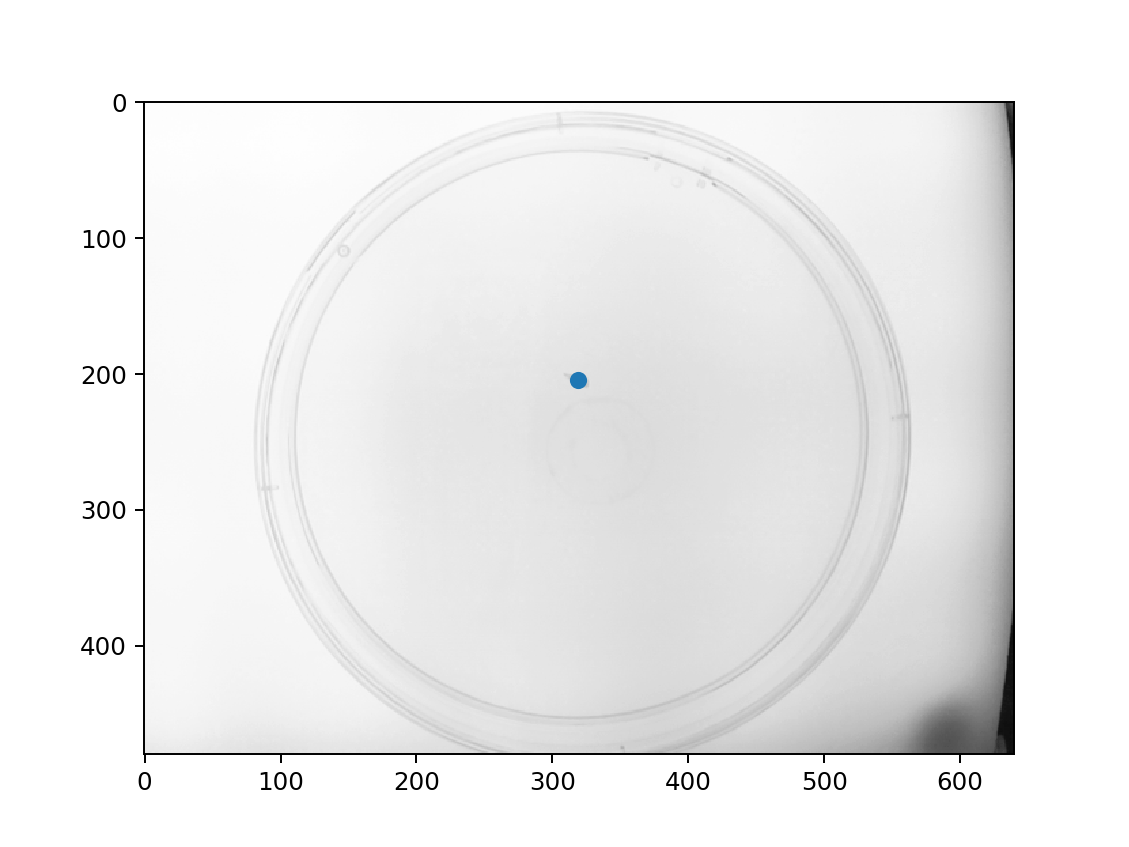

In [11]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(all_images[:,:,0], cmap='Greys_r')
#ax.imshow(thresh_image)
ax.scatter(x=first_roi.centroid_col, y=first_roi.centroid_row)

In [12]:
start_frame = counter
frame_number = all_images.shape[2]
smoothed_background = smoothed_goodbackground
frames_to_define_orientation=5
repair_ht_swaps = True

# first_roi is an instance of a class - take y (row) min and max and x (column) min amd max of the search box
first_row_min = first_roi.row_min
first_row_max = first_roi.row_max
first_col_min = first_roi.col_min
first_col_max = first_roi.col_max

# first search box

# Search Box is the part of the image the algorithm will be looking for an animal in the next frame. It has
# four variables, row_min (minimal y value), row_max (maximal  y value), col_min (minimal x value) and col_max
# (maximal x value). The search box is defined as the bounding box of the animal + a boxsize which should be
# dynamic in the future!
search_boxes = np.zeros((frame_number, 4),
                        dtype=np.int16)  # must be possible to go negative, otherwise if goes below 0 goes to 32K!
search_boxes[start_frame, :] = [int(np.round(first_row_min - boxsize)),
                                  int(np.round(first_row_max + boxsize)),
                                  int(np.round(first_col_min - boxsize)),
                                  int(np.round(first_col_max + boxsize))]


centroids = np.zeros((frame_number, 2), dtype=np.int16)
midpoints = np.zeros((frame_number, 2), dtype=np.int16)
length_skeleton = np.zeros((frame_number), dtype=np.uint16)

tails = np.zeros((frame_number, 2), dtype=np.int16)
heads = np.zeros((frame_number, 2), dtype=np.int16)
endpoints = np.zeros((2, 2, frame_number), dtype=int)
ht_swap = np.zeros((frame_number), dtype=np.bool_)

size_of_expected_animals = 20
image_raw = np.zeros((int(np.ceil(size_of_expected_animals * 2)),
                           int(np.ceil(size_of_expected_animals * 2)),
                           frame_number), dtype=np.uint8)

image_thresh = np.zeros((int(np.ceil(size_of_expected_animals * 2)),
                              int(np.ceil(size_of_expected_animals * 2)),
                              frame_number), dtype=np.bool_)
image_skel = np.zeros((int(np.ceil(size_of_expected_animals * 2)),
                            int(np.ceil(size_of_expected_animals * 2)),
                            frame_number), dtype=np.bool_)

to_fix = []



############################
# in tracking animal function
############################
i_tracking = 1

for i_tracking in range(1,all_images.shape[2]-1):
#for i_tracking in range(1,350):
    current_frame = all_images[:, :, i_tracking]

    # on the edge - this becomes necessary when the animal is close to the boundary of the frame. Due to the
    # boxsize it can happen that the animal is still well in the frame, but the boxsize ask the program to
    # look for the larva outside of the frame - which will lead to an error
    if search_boxes[i_tracking, 0] < 0:
        search_boxes[i_tracking, 0] = 0
    if search_boxes[i_tracking, 1] > smoothed_background.shape[0]:
        search_boxes[i_tracking, 1] = smoothed_background.shape[0] - 1
    if search_boxes[i_tracking, 2] < 0:
        search_boxes[i_tracking, 2] = 0
    if search_boxes[i_tracking, 3] > smoothed_background.shape[1]:
        search_boxes[i_tracking, 3] = smoothed_background.shape[1]

    # filter the image to get rid of camera noise. Only take the search box
    smoothed_current_local_image = ndimage.filters.gaussian_filter(
        CallBoundingBox(current_frame, search_boxes[i_tracking, :]).sliced_image, sigma=1)

    # take only the slice from the backgroudn image that is necessary to compare
    smoothed_background_local_image = \
        CallBoundingBox(smoothed_background, search_boxes[i_tracking, :]).sliced_image

    # We have to change the datatype of the numpy array from originally unsigned int 8 (goes from 0 to 255)
    # to signed int 16 (goes from -32768 to 32767). The reason being that if we subtract a two uint8 pictures
    # in case we have 200-201 = 255 while 200 - 199 = 1. This leads the histogram of intensites to have 2
    # background peaks, one around 0 and the other around 255. In int16 space, on the other hand, we'll have
    # the background mean at around 0 while the animal will be in the negative range
    subtracted_current_frame = smoothed_current_local_image.astype(
        np.int16) - smoothed_background_local_image.astype(np.int16)

    # calculate the local threshold
    current_thresh = MeanThresh(subtracted_current_frame, 'dark', 3)


    compare = operator.lt
    box_intensity = 0
    # calculate the binary local image
    current_image_thresholded = compare(subtracted_current_frame, current_thresh.thresh)
    # use the regionprops function to identify blobs and characterize them
    # http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
    animal_properties_current = regionprops(label(current_image_thresholded))

    # find the LARGEST blob in the search image and set it as the animal
    current_animal = DescribeLargestObject(animal_properties_current,
                                               search_boxes[i_tracking, 0::2])

    # use the bounding box of the largest blob (defined as animal) plus a given boxsize as the next search box
    search_boxes[i_tracking + 1, :] = [int(np.round(current_animal.row_min - boxsize)),
                                       int(np.round(current_animal.row_max + boxsize)),
                                       int(np.round(current_animal.col_min - boxsize)),
                                       int(np.round(current_animal.col_max + boxsize))]

    # get the current width and height of the bounding box
    current_width = current_animal.row_max - current_animal.row_min
    current_height = current_animal.col_max - current_animal.col_min
    
    # save the raw image in the preallocated image array.
    # This will fail if your animal is bigger than 2* the bounding box!
    image_raw[0:current_width, 0:current_height, i_tracking] = CallImageROI(current_frame, current_animal).small_image.copy()

    # save the binary image in the preallocated image array
    # todo - get rid of this and just save the value for the threshold. Can be reconstructed later if user
    # wants to view it. Will save a lot of memory.
    image_thresh[0:current_width, 0:current_height, i_tracking] = CallImageROI(current_image_thresholded, current_animal,
                         sliced_input_image=search_boxes[i_tracking,0::2]).small_image.copy()


    # save the bounding box coordinates. This is necessary to reconstruct the image as only this part of the
    # image is being saved.
    bounding_boxes[:, i_tracking] = [current_animal.row_min, current_animal.row_max,
                                     current_animal.col_min, current_animal.col_max].copy()
    
    # ... and the centroid
    centroids[i_tracking, :] = current_animal.centroid_row, current_animal.centroid_col


    image_skel[:, :, i_tracking] = morphology.skeletonize(image_thresh[:, :, i_tracking])
    
   # how many points are there in the skeleton (also gives me the length)
    length_skeleton[i_tracking] = len(np.nonzero(image_skel[:, :, i_tracking])[0])


    # todo: This is very explicit - change?
    skeleton_y = np.nonzero(image_skel[:, :, i_tracking])[0]
    skeleton_x = np.nonzero(image_skel[:, :, i_tracking])[1]
    # this loop will give me an array, which is organized like the current_skeleton, and tells me how many
    # points each point is connected to +1 in all 4 directions possible. Taken from original SOS.
    connect = np.zeros(length_skeleton[i_tracking])
    for i_skel in range(length_skeleton[i_tracking]):
        connect[i_skel] = np.sum(np.logical_and(skeleton_x >= skeleton_x[i_skel] - 1,
                                                np.logical_and(skeleton_x <= skeleton_x[i_skel] + 1,
                                                               np.logical_and(
                                                                   skeleton_y >= skeleton_y[i_skel] - 1,
                                                                   skeleton_y <= skeleton_y[i_skel] + 1))))
    skeleton_end_points = np.where(connect == 2)[0]

    aspect_ratio = current_animal.major_axis / current_animal.minor_axis

    if len(skeleton_end_points) == 2:
        endpoints[0, :, i_tracking] = current_animal.row_min + skeleton_y[skeleton_end_points[0]], \
                                                current_animal.col_min + skeleton_x[skeleton_end_points[0]]
        endpoints[1, :, i_tracking] = current_animal.row_min + skeleton_y[skeleton_end_points[1]], \
                                                current_animal.col_min + skeleton_x[skeleton_end_points[1]]

    # need to add midpoint of the skeleton
    # take half the lenght of the skeleton
    temp_midpoint = length_skeleton[i_tracking] / 2
    # if the skeleton length is an even number add one (e.g. the center point of 4 points can either be position 2
    # or position 3.)
    if temp_midpoint % 2 == 0:
        temp_midpoint += 1
    # the the skeleton length is an odd number, add half (e.g. center point of 5 numbers is 3
    else:
        temp_midpoint += 0.5
    try:
        midpoints[i_tracking, :] = current_animal.row_min + skeleton_y[int(temp_midpoint)], \
                                             current_animal.col_min + skeleton_x[int(temp_midpoint)]
    except IndexError:  # if animal is extremely small!
        midpoints[i_tracking, :] = current_animal.row_min, current_animal.col_min
        
        
        
        
    #####################################
    
    # rules to be able to get to assign head and tail to an image:
    # 1): aspect ratio (major axis / minor axis of the animal must be higher than a given value
    # 2): We need exactly two endpoints on the skeleton (when one has holes in the binary image it can become a
    # a circular skeleton
    # 3): We need a minimum length of the skeleton.
    if aspect_ratio > 1.25 and len(skeleton_end_points) == 2 and \
                    length_skeleton[i_tracking] > 1 / \
                    2 * np.nanmean(length_skeleton[i_tracking - 3:i_tracking]):

        # in case we have not yet assigned the head, at the beginning of the experiment
        # which endpoint has the shortest distance to the centroid of the original larva = tail
        if i_tracking == start_frame:
            # if self.tails[self.i_tracking-1,0] == 0:
            if np.linalg.norm(first_centroid - endpoints[0, :, i_tracking]) < np.linalg.norm(
                            first_centroid - endpoints[1, :, i_tracking]):  # endpoint 0 is the tail
                tails[i_tracking, :] = endpoints[0, :, i_tracking]
                heads[self.i_tracking, :] = endpoints[1, :, i_tracking]
            else:
                tails[self.i_tracking, :] = endpoints[1, :, i_tracking]
                heads[self.i_tracking, :] = endpoints[0, :, i_tracking]
        elif tails[i_tracking - 1, 0] == 0:
            # This happens when you have a donut shaped larva in the frames before.
            # idea: The last verified centroid should always be closer to the tail than the head, which can move
            # much more
            if np.linalg.norm(endpoints[0, :, i_tracking] - centroids[to_fix[0] - 1, :]) < \
                    np.linalg.norm(endpoints[1, :, i_tracking] - centroids[to_fix[0] - 1, :]):
                tails[i_tracking, :] = endpoints[0, :, i_tracking]
                heads[self.i_tracking, :] = endpoints[1, :, i_tracking]
            else:
                tails[self.i_tracking, :] = endpoints[1, :, i_tracking]
                heads[self.i_tracking, :] = endpoints[0, :, i_tracking]

            # we'll also fix, in retrospect, the lost self.heads and self.tails with the centroid coordinate
            # to easily be able to plot afterwards
            tails[self.to_fix, :] = centroids[to_fix, :].copy()
            heads[self.to_fix, :] = centroids[to_fix, :].copy()

            to_fix = []
        else:
            if np.linalg.norm(tails[i_tracking - 1, :] - endpoints[0, :, i_tracking]) < np.linalg.norm(
                            tails[i_tracking - 1, :] - endpoints[1, :, i_tracking]):
                tails[i_tracking, :] = endpoints[0, :, i_tracking]
                heads[i_tracking, :] = endpoints[1, :, i_tracking]
            else:
                tails[i_tracking, :] = endpoints[1, :, i_tracking]
                heads[i_tracking, :] = endpoints[0, :, i_tracking]

        # the if clause below checks if the tail is in front of the the centroid, essentially checking if
        # there's a potential head/tail swap in the assignment.

        # First if just checks if there have been enough frames collected already to compare with the
        # current frame.
        if i_tracking > recording_framerate:
            # First we calculate the distance of the centroid between the past 1 second and the
            # current frame. This will be needed to calculate speed
            distance_centroid = np.linalg.norm(
                centroids[i_tracking - recording_framerate, :] - centroids[i_tracking, :])
            # print('Distance in pixels: ' + repr(distance_centroid))
            # print('Distance in mm: ' + repr(distance_centroid/self.pixel_per_mm))


            # next there is a filter for the minimum speed of the centroid needs to have in order to consider
            # the animal 'running'. For now this is set to 0.5mm/s
            # speed mm per sec = distance centroid / px_per_mm  / framerate
            current_centroid_speed = (distance_centroid / pixel_per_mm) / recording_framerate
            if tails[i_tracking - 1, 0] != 0 and tails[i_tracking, 0] != 0 and \
                            current_centroid_speed > 0.25:
                # we'll check if a tail has been asigned or if the curvature of the animal was too great.
                # then it checks if the distance travelled was enough to justify looking for a H/T swap

                # this first checks in which direction the centroid is traveling relative to the frame before:
                # theta_centroid = centroid _current - centroid_past
                direction_centroid = np.arctan2(centroids[i_tracking, 0] -
                                                centroids[
                                                    i_tracking - frames_to_define_orientation, 0],
                                                centroids[i_tracking, 1] -
                                                centroids[
                                                    i_tracking - frames_to_define_orientation, 1])
                # if the centroid is in front of the tail, we'll always get a similar angle as the
                # direction of centroid if the trail is in front of the centroid (H/T sway) we should get
                # the opposite angle theta_tail = centroid_current - tail_current
                direction_tail_minus_centroid = np.arctan2(centroids[i_tracking, 0] -
                                                           tails[i_tracking, 0],
                                                           centroids[i_tracking, 1] -
                                                           tails[i_tracking, 1])
                # next we'll normalize, i.e. we bring the movement of the centroid onto the horizonal axis
                # and let the direction of the tail relative to the centroid follow
                if direction_centroid - direction_tail_minus_centroid < -np.pi or direction_centroid - \
                        direction_tail_minus_centroid > np.pi:
                    normalized_angle = direction_centroid + direction_tail_minus_centroid
                else:
                    normalized_angle = direction_centroid - direction_tail_minus_centroid

                # now we can just check if the normalized angle is bigger or smaller than given freedom we
                # give it
                if normalized_angle > 1 / 2 * np.pi or normalized_angle < - 1 / 2 * np.pi:
                    print('found HT swap frame ' + repr(i_tracking))
                    print('movement: ' + repr(direction_centroid))
                    print('tail dir: ' + repr(direction_tail_minus_centroid))
                    ht_swap[i_tracking] = 1

                    if repair_ht_swaps:

                        # In order to be robust against noise the heat tail swap needs to persistent for
                        # at least one second - Todo Results for framerate 1 may be problematic!
                        if (ht_swap[i_tracking - recording_framerate:i_tracking] == 1).all():
                            print('now I could repair the ht swaps')
                            tails_temp = np.zeros((recording_framerate, 2), dtype=np.int16) 
                            heads_temp = np.zeros((recording_framerate, 2), dtype=np.int16)

                            np.copyto(tails_temp,
                                      heads[int(i_tracking - recording_framerate + 1):i_tracking + 1, :])
                            np.copyto(heads_temp,
                                      tails[int(i_tracking - recording_framerate + 1):i_tracking + 1, :])

                            np.copyto(tails[int(i_tracking - recording_framerate + 1):i_tracking + 1, :],
                                      tails_temp)
                            np.copyto(heads[int(i_tracking - recording_framerate + 1):i_tracking + 1, :],
                                      heads_temp)

                            ht_swap[i_tracking - recording_framerate + 1:i_tracking + 1] = 0

    else:
        # need to assign the cnetroid position to the head/tail - otherwise in the VR setting we have
        # huge jumps!
        tails[i_tracking, :] = centroids[i_tracking, :]
        heads[i_tracking, :] = centroids[i_tracking, :]
        to_fix.append(i_tracking)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in greater


found HT swap frame 3
movement: 0.5767164
tail dir: -2.782822
found HT swap frame 4
movement: 0.577405
tail dir: -2.6779451
found HT swap frame 5
movement: 0.57810193
tail dir: -2.7233684
now I could repair the ht swaps
found HT swap frame 6
movement: -2.7985687
tail dir: 0.5585993
found HT swap frame 7
movement: -2.7291822
tail dir: 0.7086263
found HT swap frame 8
movement: -2.6516354
tail dir: 0.35877067
now I could repair the ht swaps
found HT swap frame 201
movement: 2.3561945
tail dir: -0.6202495
found HT swap frame 387
movement: -2.0344439
tail dir: 0.124354996
found HT swap frame 388
movement: -2.6779451
tail dir: 0.11065722
found HT swap frame 389
movement: -2.819842
tail dir: 0.0
now I could repair the ht swaps
found HT swap frame 396
movement: -0.71883
tail dir: 2.2318394
found HT swap frame 399
movement: -0.71883
tail dir: 2.4329665
found HT swap frame 400
movement: -0.7853982
tail dir: 2.5213432
found HT swap frame 402
movement: -0.7853982
tail dir: 2.2794225
found HT swap 

<IPython.core.display.Javascript object>


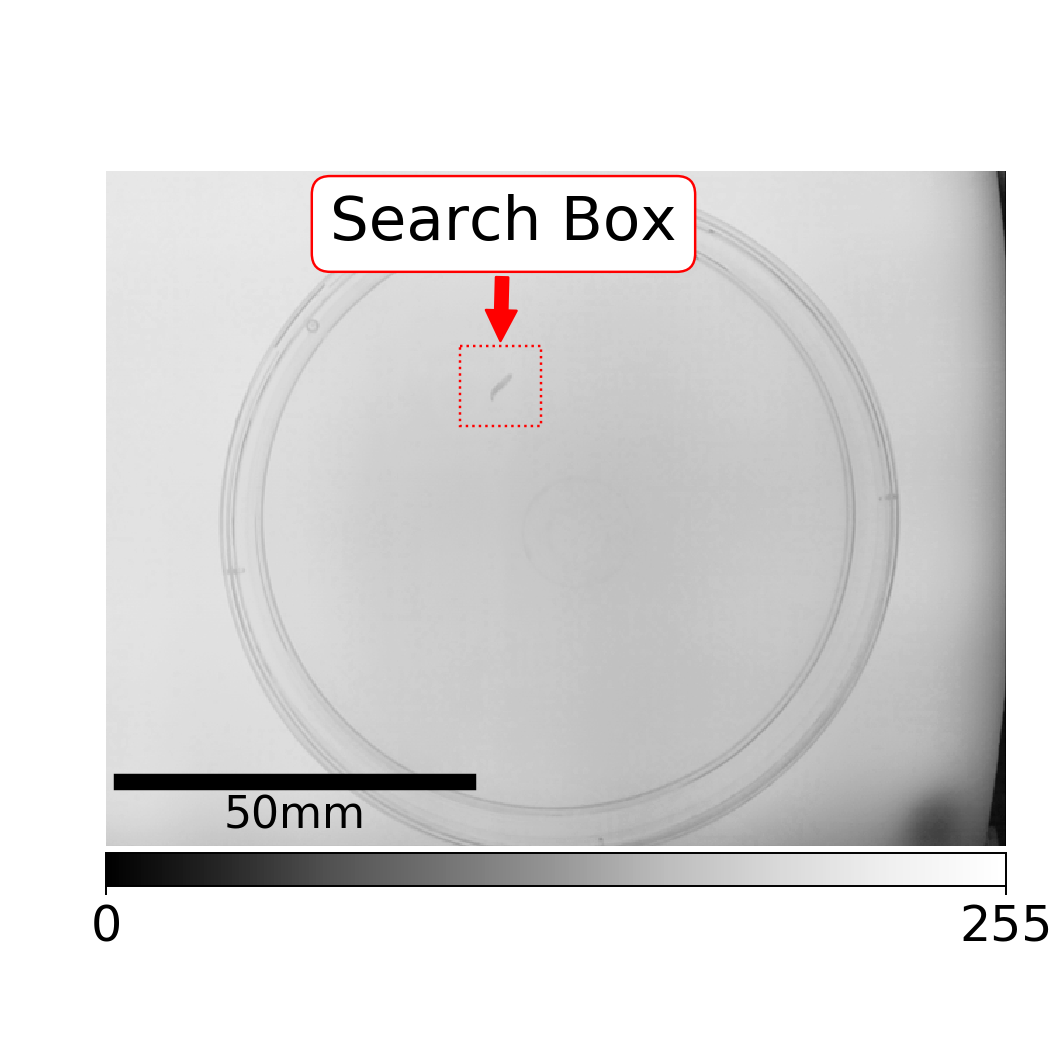

In [13]:
txt_x_displacement = -150
txt_y_displacement = -75


fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111)
plot = ax.imshow(all_images[:,:,i_tracking], cmap='Greys_r', vmin=0, vmax=255)
# Create a Rectangle patch
rect = patches.Rectangle((search_boxes[i_tracking, 2],search_boxes[i_tracking, 0] ),
                         search_boxes[i_tracking, 3]-search_boxes[i_tracking, 2],
                         search_boxes[i_tracking, 1]-search_boxes[i_tracking, 0],
                         linewidth=1,edgecolor='r',facecolor='none',ls=':', lw=1)
ax.axis('off')
ax.annotate('Search Box', xy=(search_boxes[i_tracking, 3]-(search_boxes[i_tracking, 3]-search_boxes[i_tracking,2])/2, 
                              search_boxes[i_tracking, 0],), xycoords='data', 
                  xytext=(search_boxes[i_tracking, 3]+txt_x_displacement, 
                          search_boxes[i_tracking, 0]+txt_y_displacement), 
            arrowprops=dict(arrowstyle="simple", color='r'), size=25,
                  bbox=dict(boxstyle="round", fc="w", ec="r"))
# Add the patch to the Axes
ax.add_patch(rect)
#ax.set_title('Original Frame', fontsize=25)

# add scalebar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           50*pixel_per_mm, '50mm', 
                           'lower left',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=10,
                           fontproperties=fontprops)
ax.add_artist(scalebar) 
#fig.tight_layout()
ax.axis('off')
#ax3.set_title('Search Box Subtracted', fontsize=25)
# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot, 
                  orientation="horizontal", 
                  ticks=[0,255], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([0,255], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40

fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4a_FlowchartIndicateSearchBox.eps')

<IPython.core.display.Javascript object>


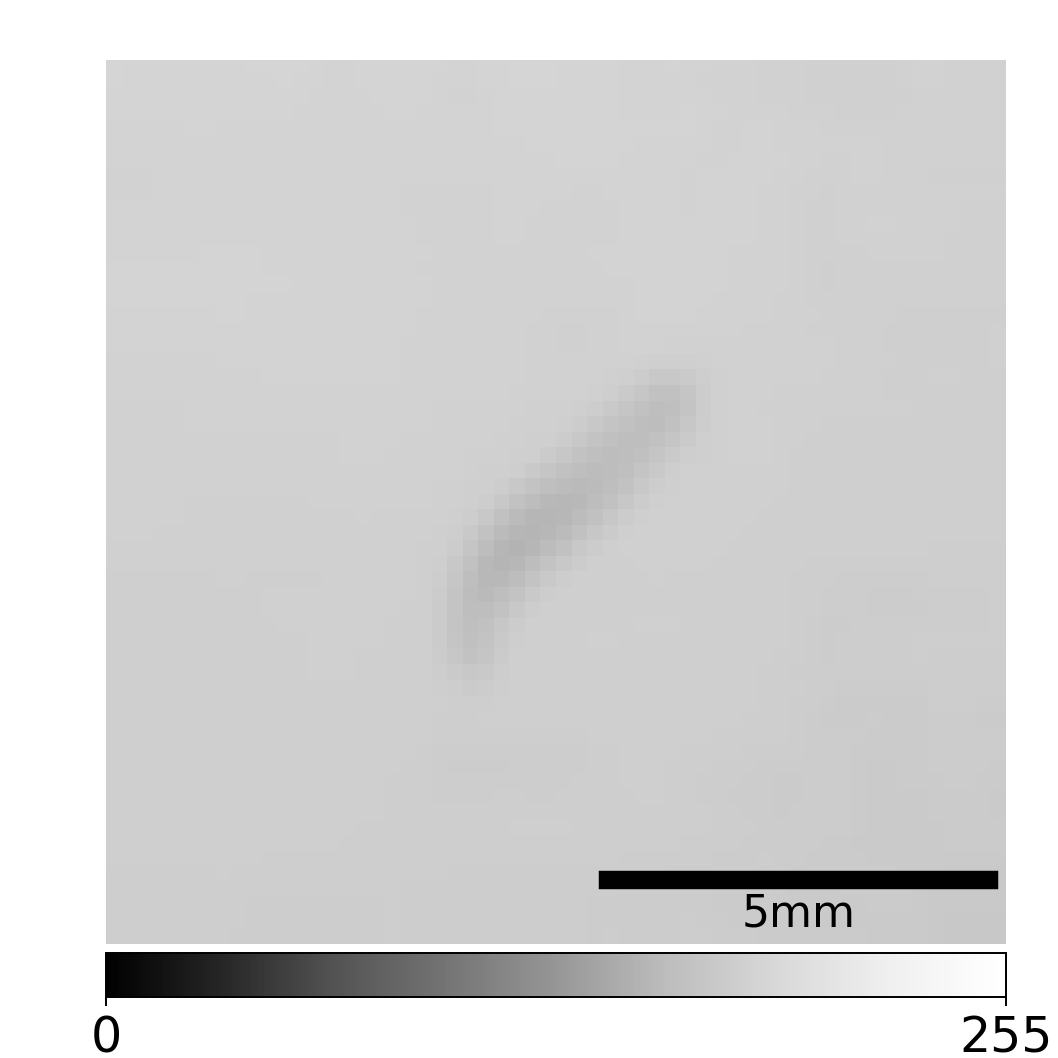

In [14]:
# SMALL IMAGE ORIGNAL
#gs = gridspec.GridSpec(1, 6)
fig=plt.figure(figsize=(6,6))
#fig=plt.figure(figsize=(12,2))
ax1=fig.add_subplot(111)
# turn of the x and y ticks
ax1.set_xticks([])
ax1.set_yticks([])
plot1 = ax1.imshow(smoothed_current_local_image, cmap='Greys_r',vmin=0, vmax=255)
#ax1.tick_params(
#    axis='both',          # changes apply to the both axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    left=False,         # ticks along the left edge are off
#    labelbottom=False,
#    labelleft=False) 
#ax1.set_title('Search Box Original', fontsize=25)


# add scalebar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax1.transData,
                           5*pixel_per_mm, '5mm', 
                           'lower right',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax1.add_artist(scalebar) 

ax1.axis('off')
#ax3.set_title('Search Box Subtracted', fontsize=25)
# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax1)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot1, 
                  orientation="horizontal", 
                  ticks=[0,255], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([0,255], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40

fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4c_SmallImageOriginal.eps')

<IPython.core.display.Javascript object>


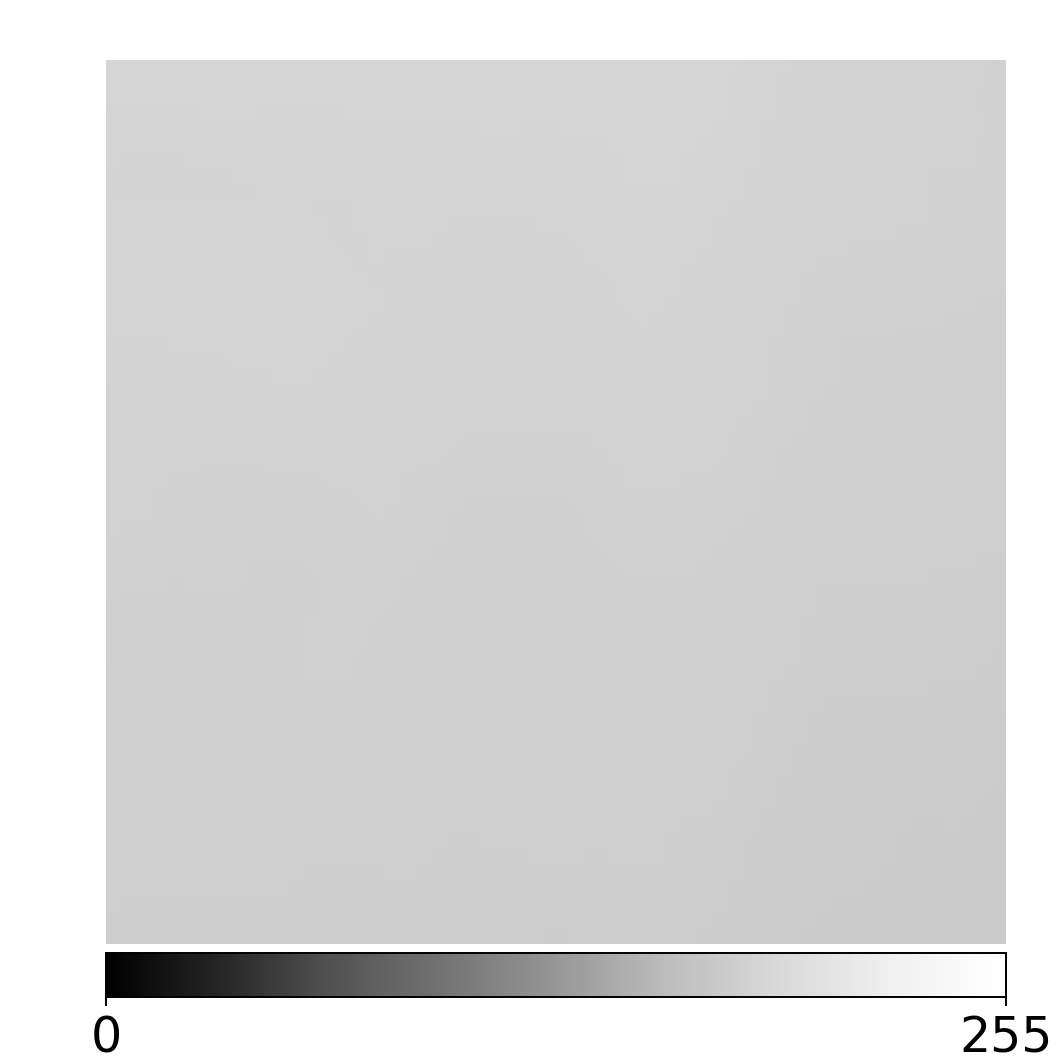

In [15]:
fig=plt.figure(figsize=(6,6))
ax2=fig.add_subplot(111)
plot2 = ax2.imshow(smoothed_background_local_image, cmap='Greys_r',vmin=0, vmax=255)
# turn of the x and y ticks
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')
#ax2.tick_params(
#    axis='both',          # changes apply to the both axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    left=False,         # ticks along the left edge are off
#    labelbottom=False,
#    labelleft=False) 
#ax2.set_title('Search Box Background', fontsize=25)

#ax3.set_title('Search Box Subtracted', fontsize=25)
# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax2)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot2, 
                  orientation="horizontal", 
                  ticks=[0,255], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([0,255], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40

fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4b_SmallImageBackground.eps')

<IPython.core.display.Javascript object>


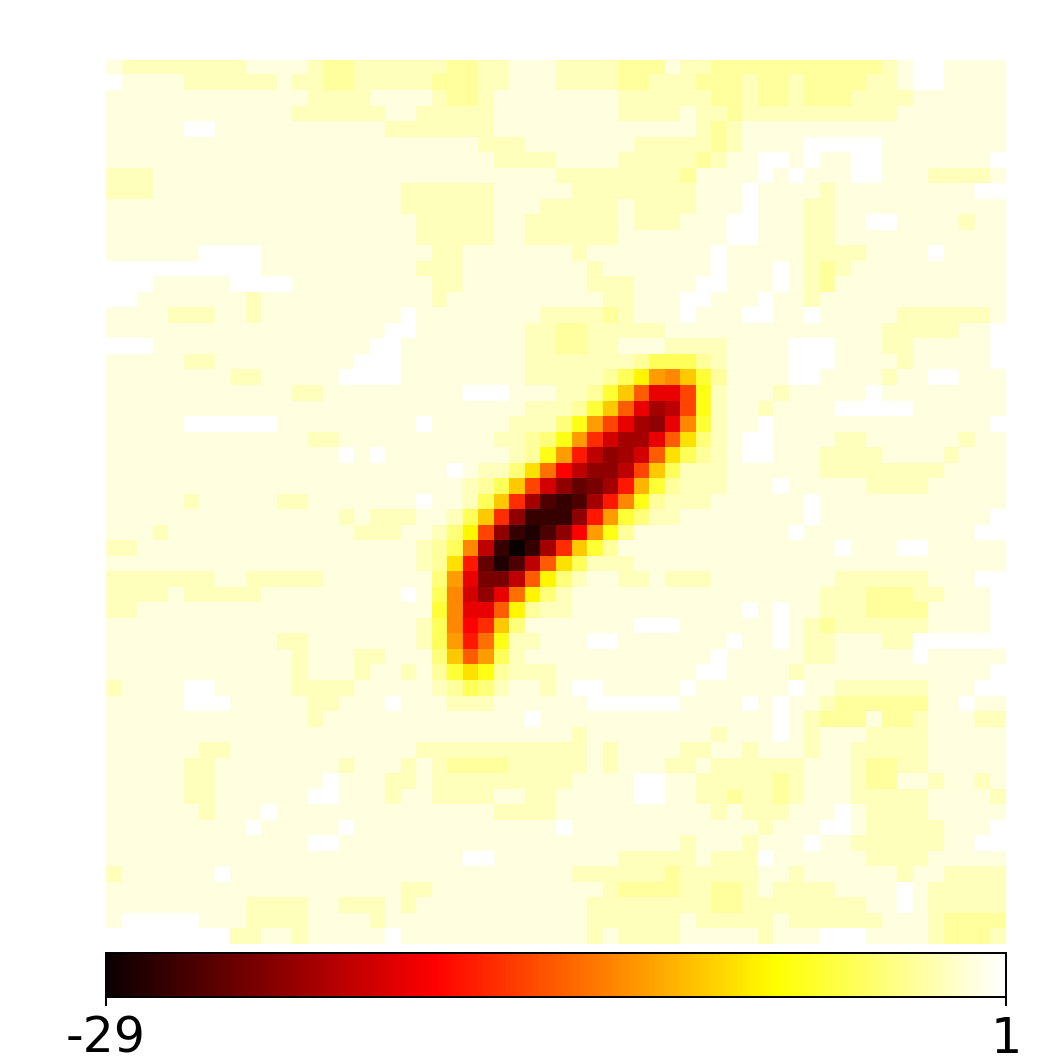

In [16]:
fig=plt.figure(figsize=(6,6))
ax3=fig.add_subplot(111)
plot3 = ax3.imshow(subtracted_current_frame, cmap='hot')
# turn of the x and y ticks
ax3.set_xticks([])
ax3.set_yticks([])
#ax3.tick_params(
#    axis='both',          # changes apply to the both axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    left=False,         # ticks along the left edge are off
#    labelbottom=False,
#    labelleft=False) 
ax3.axis('off')
#ax3.set_title('Search Box Subtracted', fontsize=25)
# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax3)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot3, 
                  orientation="horizontal", 
                  ticks=[np.amin(subtracted_current_frame),
                         np.amax(subtracted_current_frame)], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([np.amin(subtracted_current_frame),
                         np.amax(subtracted_current_frame)], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40

fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4d_SmallImageSubtracted.eps')

<IPython.core.display.Javascript object>


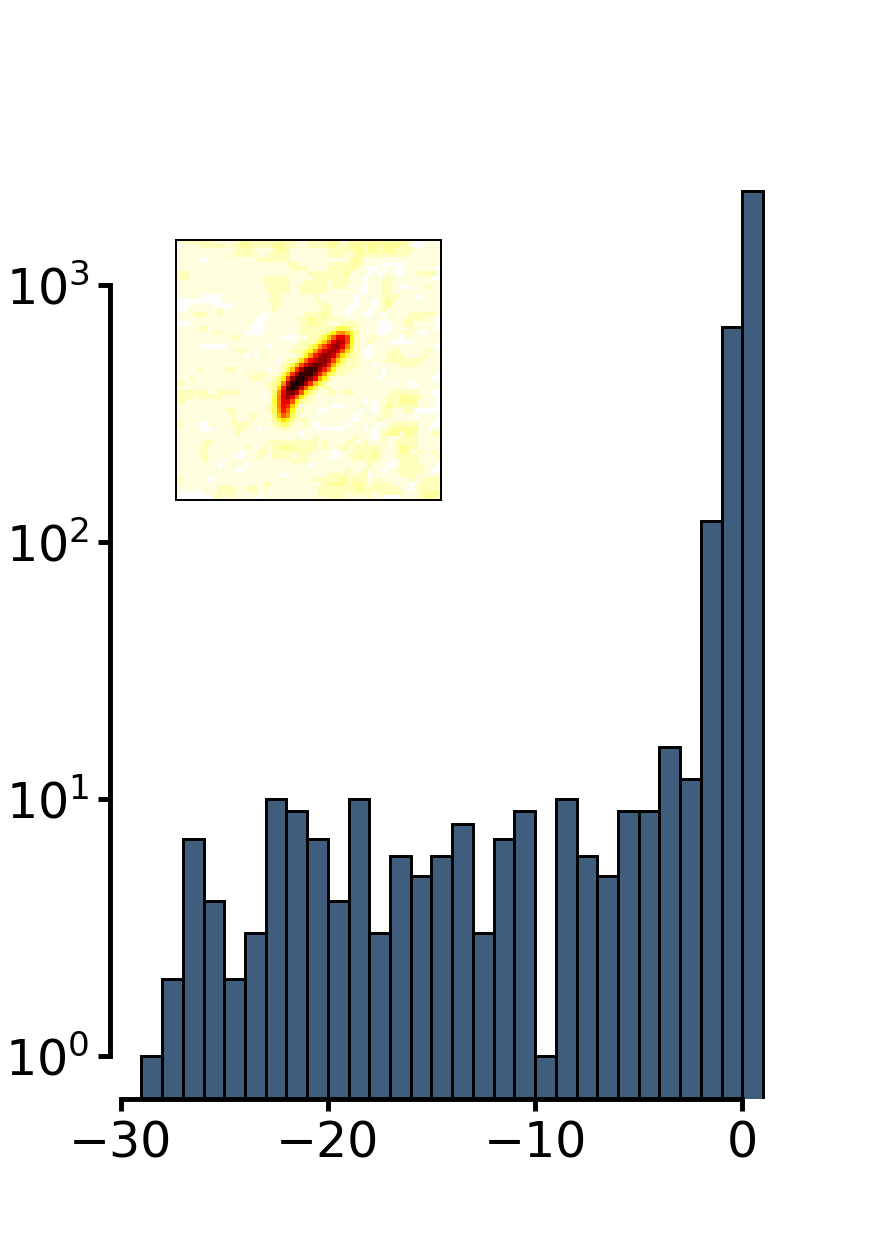

In [17]:
fig=plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)
ax_image = fig.add_axes([0.2,0.5,0.3,0.4])

ax.hist(subtracted_current_frame.ravel(), bins=30,color="#3F5D7D",edgecolor='black', linewidth=1.2,zorder=0)
ax.set_yscale("log", nonposy='clip')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_image.imshow(subtracted_current_frame, 'hot',zorder=1)
ax_image.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 


# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=2, length =5)
ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)

# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(1, 1000)

ax.spines['bottom'].set_bounds(-30,0)

# turn minor ticks off (make a mess in the illustrator file)
ax.minorticks_off()

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4e_HistogramSubtracted.eps')#, rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


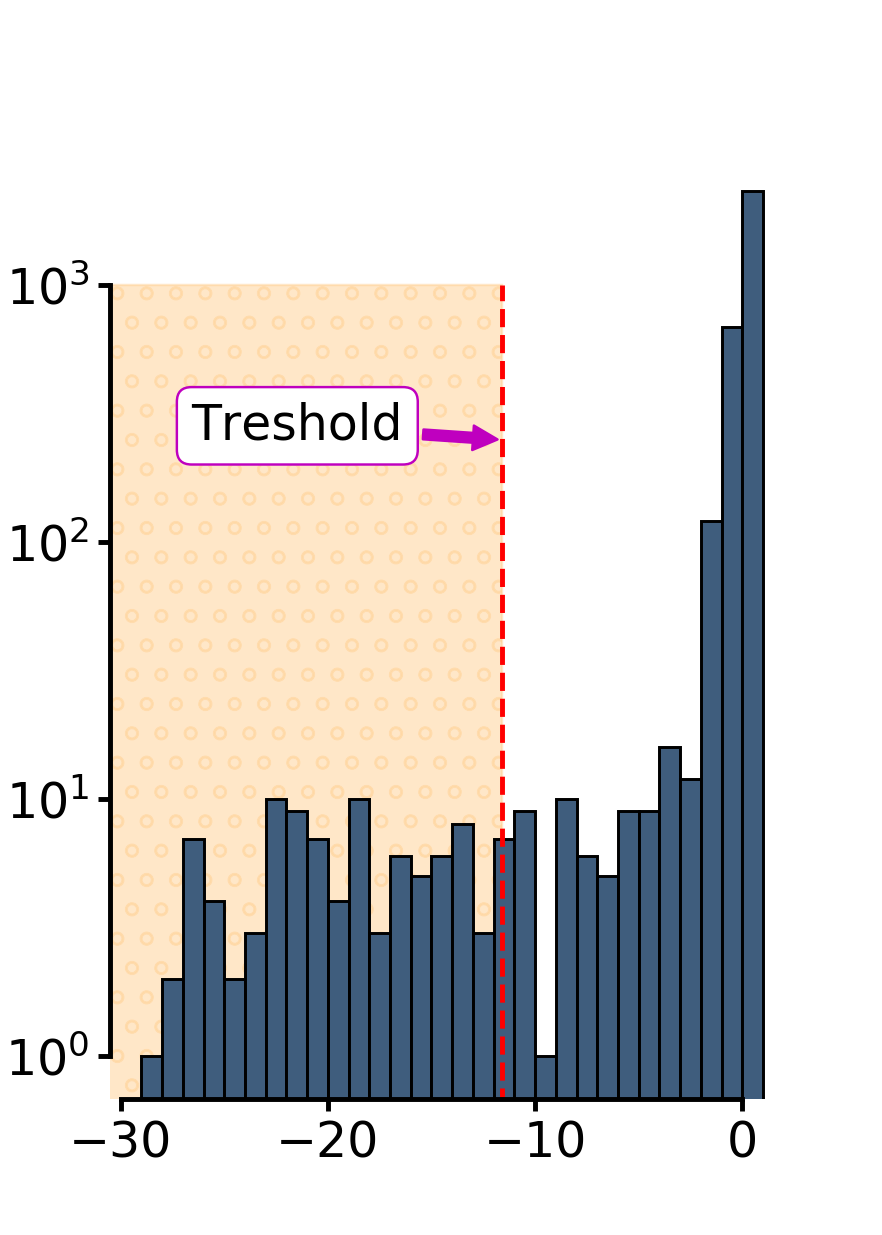

In [18]:
fig=plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

ax.hist(subtracted_current_frame.ravel(), bins=30,color="#3F5D7D",edgecolor='black', linewidth=1.2,zorder=0)
ax.set_yscale("log", nonposy='clip')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot([np.nanmean(subtracted_current_frame) - np.std(subtracted_current_frame)*3, 
        np.nanmean(subtracted_current_frame) - np.std(subtracted_current_frame)*3], 
        [0,1000], c='r', ls='--', lw=2)
# set the y axis limit
#ax.set_ylim(0,270000)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(1, 1000)

ax.spines['bottom'].set_bounds(-30,0)

# draw another rectangle in the background to indicate what the signal will be 
rect = patches.Rectangle((np.nanmean(subtracted_current_frame) - np.std(subtracted_current_frame)*3,0),
                         -255, 
                         1000,linewidth=1,
                         edgecolor='#ffd193ff',facecolor='#ffd193ff', fill=True, alpha = 0.5,
                         hatch='o', label='Signal',zorder=-1)
ax.add_patch(rect)

txt_x_displacement = -15
txt_y_displacement = -500
np.nanmean(subtracted_current_frame) - np.std(subtracted_current_frame)*3
ax.annotate('Treshold', xy=(np.nanmean(subtracted_current_frame) - np.std(subtracted_current_frame)*3,250),
            xycoords='data', 
            xytext=((np.nanmean(subtracted_current_frame) - np.std(subtracted_current_frame)*3)+txt_x_displacement, 
                        250), 
            arrowprops=dict(arrowstyle="simple", color='m'), size=20,
                  bbox=dict(boxstyle="round", fc="w", ec="m"))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=2, length =5)
ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)

# turn minor ticks off (make a mess in the illustrator file)
ax.minorticks_off()

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4f_HistogramTresh.eps')#, rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


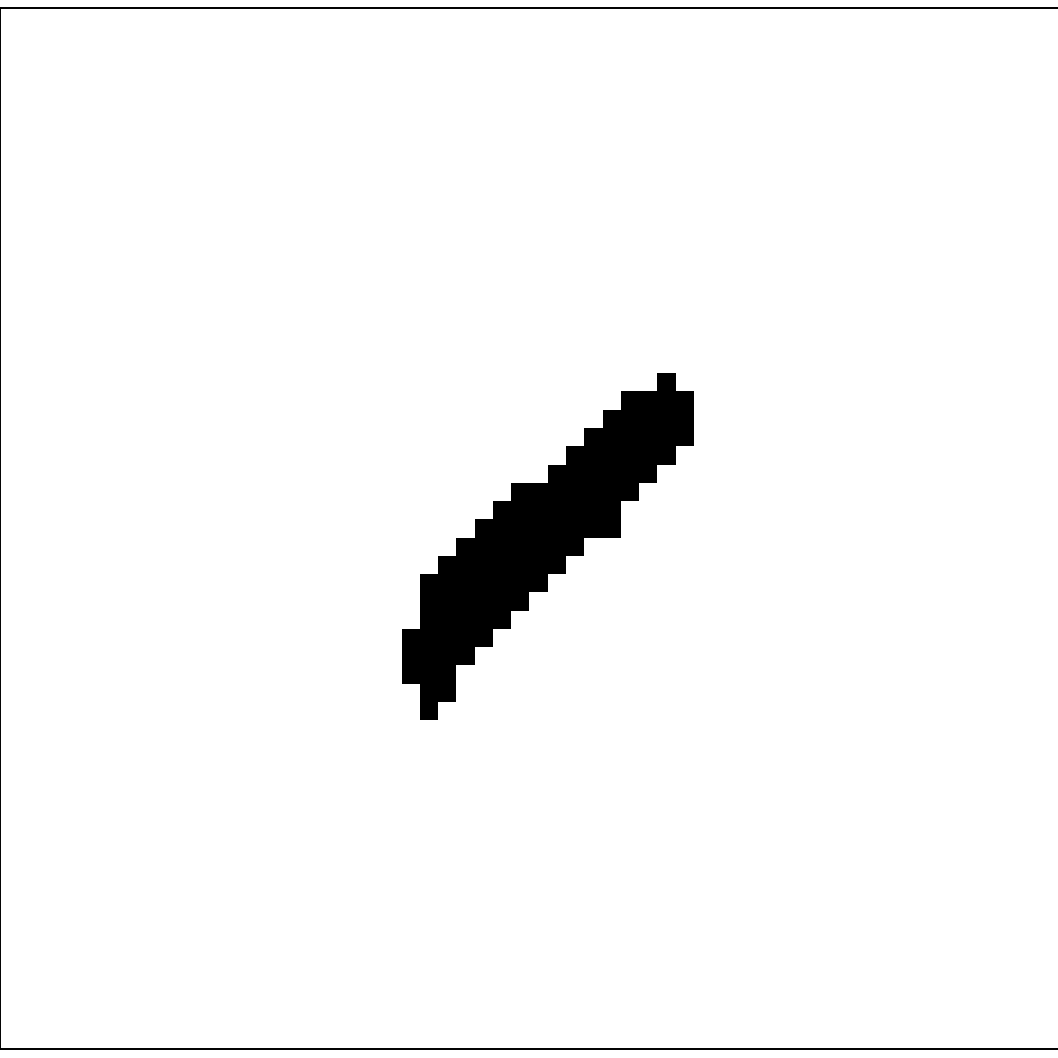

In [19]:
fig=plt.figure(figsize=(6,6))
ax6=fig.add_subplot(111)
ax6.imshow(current_image_thresholded, cmap='Greys')
ax6.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 
#ax6.set_title('Search Box Binary', fontsize=25)


fig.subplots_adjust(left=0, bottom=0, top=1, right=1) # !!!

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4g_SmallImageBinary.eps')

<IPython.core.display.Javascript object>


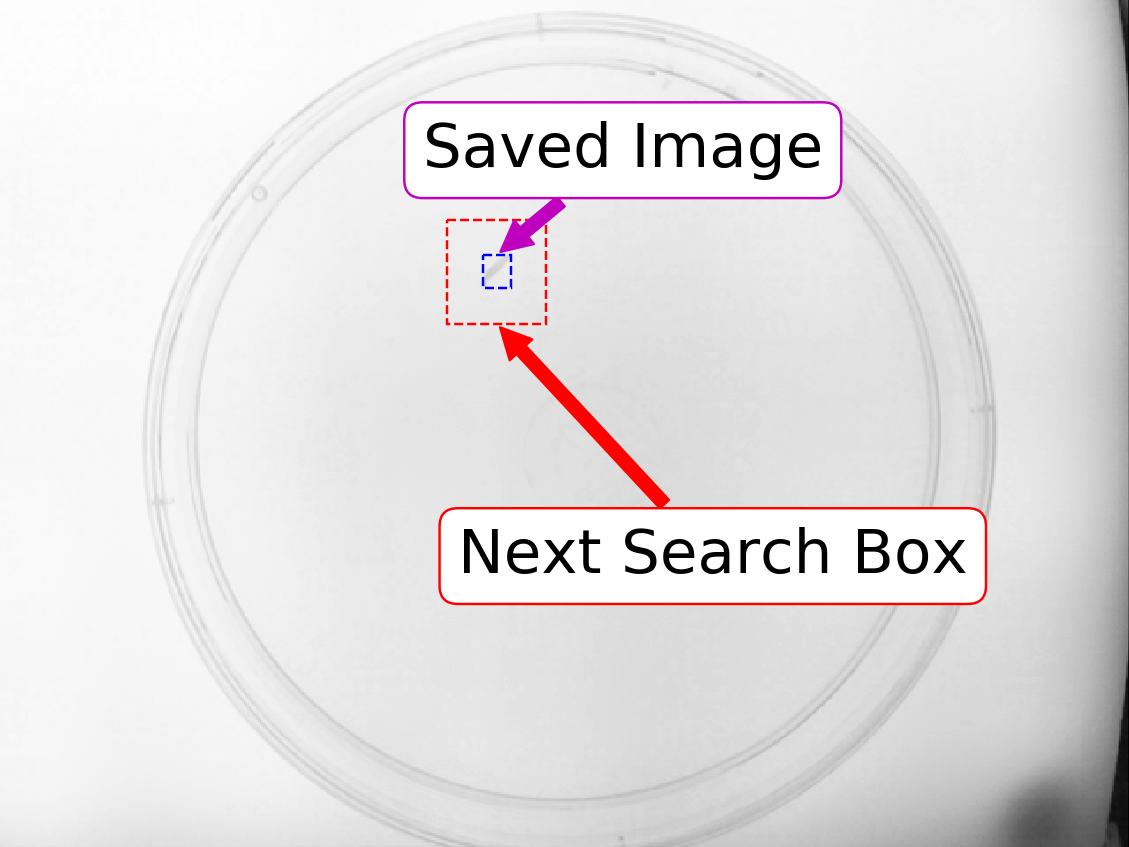

In [20]:
txt_x_displacement = -50
txt_y_displacement = -50

fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(all_images[:,:,i_tracking], cmap='Greys_r')
# Create a Rectangle patch
rect = patches.Rectangle((bounding_boxes[2,i_tracking],bounding_boxes[0,i_tracking] ),
                         bounding_boxes[3,i_tracking]-bounding_boxes[2,i_tracking],
                         bounding_boxes[1,i_tracking]-bounding_boxes[0,i_tracking],
                         linewidth=1,edgecolor='b',facecolor='none',ls='--')
ax.add_patch(rect)
ax.axis('off')

ax.annotate('Saved Image', xy=(bounding_boxes[3,i_tracking]-(bounding_boxes[3,i_tracking]-bounding_boxes[2,i_tracking])/2, 
                              bounding_boxes[0,i_tracking],), xycoords='data', 
                  xytext=(bounding_boxes[3,i_tracking]+txt_x_displacement, 
                          bounding_boxes[0,i_tracking]+txt_y_displacement), 
            arrowprops=dict(arrowstyle="simple", color='m'), size=25,
                  bbox=dict(boxstyle="round", fc="w", ec="m"))


txt_y_displacement = 200

# Create a Rectangle patch
rect = patches.Rectangle((search_boxes[i_tracking+1, 2],search_boxes[i_tracking+1, 0] ),
                         search_boxes[i_tracking+1, 3]-search_boxes[i_tracking+1, 2],
                         search_boxes[i_tracking+1, 1]-search_boxes[i_tracking+1, 0],
                         linewidth=1,edgecolor='r',facecolor='none',ls='--')
ax.add_patch(rect)
ax.axis('off')
ax.annotate('Next Search Box', xy=(search_boxes[i_tracking+1, 3]-(search_boxes[i_tracking+1, 3]-
                                                             search_boxes[i_tracking+1,2])/2, 
                              search_boxes[i_tracking+1, 1],), xycoords='data', 
                  xytext=(search_boxes[i_tracking+1, 3]+txt_x_displacement, 
                          search_boxes[i_tracking+1, 0]+txt_y_displacement), 
            arrowprops=dict(arrowstyle="simple", color='r'), size=25,
                  bbox=dict(boxstyle="round", fc="w", ec="r"))

#ax.set_title('Animal Identified', fontsize=25)

fig.subplots_adjust(left=0, bottom=0, top=1, right=1) # !!!

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S4h_IdentifiedAnimal.eps')